# Econometrics Group Homework 1

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize

In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'

### Data import

In [3]:
df = pd.read_excel('Data_for_HW1.xlsx', sheet_name='Subset')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

# Rename columns for clarity (removing extra spaces)
df.columns = ['Price', 'Log_Return']

In [4]:
df

,Price,Log_Return
Date,,
2020-11-17,17674.9,0.056138
2020-11-18,17773.0,0.005535
2020-11-19,17810.0,0.002080
2020-11-20,18669.0,0.047104
2020-11-21,18660.0,-0.000482
...,...,...
2024-12-11,101126.2,0.046852
2024-12-12,100009.9,-0.011039
2024-12-13,101426.2,0.014162


In [5]:
df.dtypes

Price         float64
Log_Return    float64
dtype: object

### Task 1: Correlogram of Bitcoin Price Index

In [6]:
def SACF_SPACF(series, lag_max = 24, alpha_level = 0.05, model_df = 0):
    """
    Compute the sample autocorrelation function (SACF), sample partial autocorrelation function (SPACF),
    and Ljung-Box Q-statistics for a time series.

    This function calculates the ACF and PACF values along with their corresponding confidence intervals
    for lags 1 through `lag_max` using the provided significance level (`alpha_level`). In addition, it
    computes the Ljung-Box Q-statistic and associated p-values (excluding lag 0). Set `model_df`
    to the number of dof lost.

    """

    # Calculate ACF and PACF with confidence intervals
    acf_vals, acf_confint = acf(series, nlags=lag_max, alpha=alpha_level)
    pacf_vals, pacf_confint = pacf(series, nlags=lag_max, alpha=alpha_level, method='ols')

    lb_results = sm.stats.acorr_ljungbox(
        series,
        lags=range(1, lag_max + 1),
        model_df=model_df,
        return_df=True
    )

    df_acf_pacf = pd.DataFrame({
        "Lag": np.arange(1, lag_max + 1),
        "ACF": acf_vals[1:],
        "ACF_lower": acf_confint[1:, 0],
        "ACF_upper": acf_confint[1:, 1],
        "PACF": pacf_vals[1:],
        "PACF_lower": pacf_confint[1:, 0],
        "PACF_upper": pacf_confint[1:, 1],
        "Q-stat": lb_results["lb_stat"].values,
        "Q-stat Prob": lb_results["lb_pvalue"].values.round(6)
    })

    df_acf_pacf.set_index("Lag", inplace=True)
    df_acf_pacf_small = df_acf_pacf[["ACF", "PACF", "Q-stat", "Q-stat Prob"]].copy()

    return df_acf_pacf_small


In [7]:
def SACF_SPACF_plot (series, lag_max = 24, ylim = [-0.15, 0.15]):
  """
    Generate plots for the Sample Autocorrelation (SACF) and Sample Partial Autocorrelation (SPACF)
    of a time series.

  """
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # Sample Autocorrelation (SACF) Plot
  plot_acf(series, lags=lag_max, ax=axes[0], zero=False)
  axes[0].set_title("SACF")
  axes[0].set_ylim(ylim)

  # Sample Partial Autocorrelation (SPACF) Plot
  plot_pacf(series, lags=lag_max, ax=axes[1], method='ols', zero=False)
  axes[1].set_title("SPACF")
  axes[1].set_ylim(ylim)

  plt.tight_layout()
  return plt.show()

In [8]:
prices = df["Price"].values

In [9]:
prices_acf_pacf = SACF_SPACF(prices,lag_max=21)
prices_acf_pacf

,ACF,PACF,Q-stat,Q-stat Prob
Lag,,,,
1,0.992220,1.000375,1469.860464,0.0
2,0.985123,0.048529,2919.744887,0.0
3,0.977822,-0.028704,4349.176654,0.0
4,0.970758,0.001510,5758.979896,0.0
5,0.963331,-0.032256,7148.228991,0.0
6,0.956325,-0.025776,8518.266160,0.0
7,0.949298,0.013970,9869.152847,0.0
8,0.941783,-0.001928,11199.634733,0.0
9,0.934689,0.046823,12511.031692,0.0


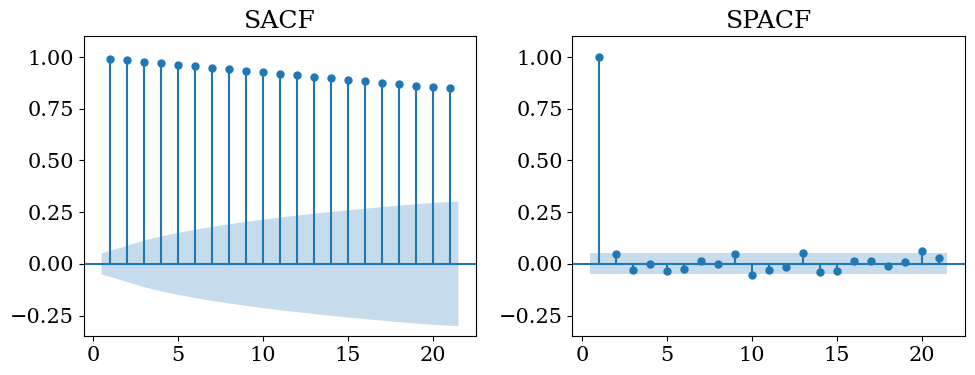

In [10]:
SACF_SPACF_plot(prices, lag_max=21, ylim=[-0.35,1.1])

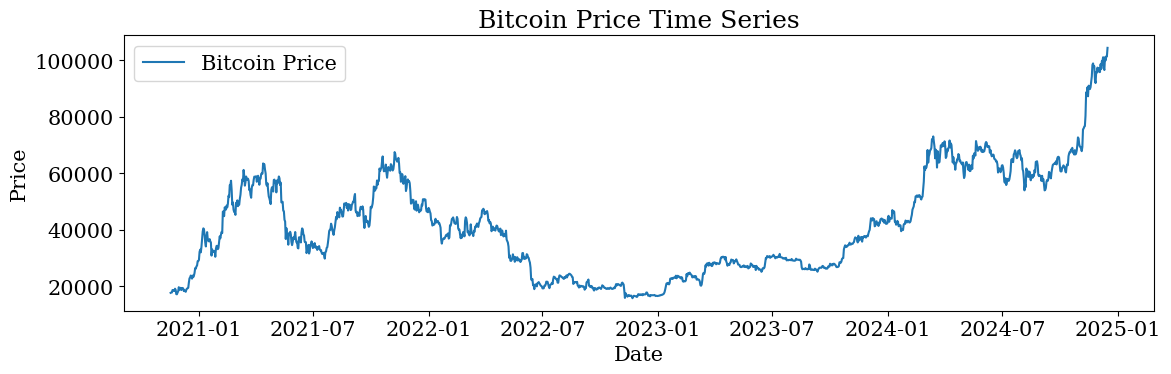

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df['Price'], label='Bitcoin Price')
plt.title('Bitcoin Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

The SACF of the Bitcoin Price Index exhibits a slow decay, with all 21 lags remaining significant and decreasing gradually from 1.0 to slightly above 0.8. This pattern, being very similar to that of a random walk, indicates strong persistence and suggests that the time series of Bitcoin price index is non-stationary. The SPACF supports this observation, displaying a significant spike at lag 1 (close to 1.0), with subsequent lags being very close to zero and within the confidence bands. Finally, the plot of the evolution of the Bitcoin price over the selected time period seems to further reinforce the thesis of this time series being non-stationary, as the values do not move around a constant but change wildly.

For proper econometric analysis, the Bitcoin Price Index should be transformed to achieve stationarity. A common and effective approach is to use the first difference of the log prices, which in our case is already provided as the Bitcoin Log Return in the dataset. This transformation removes trends and stabilizes variance, making the series suitable for models like ARIMA, and at the same time exploits the interpretability of log returns as percentage changes.

### Task 2: Histograms and Summary Statistics of Bitcoin Returns

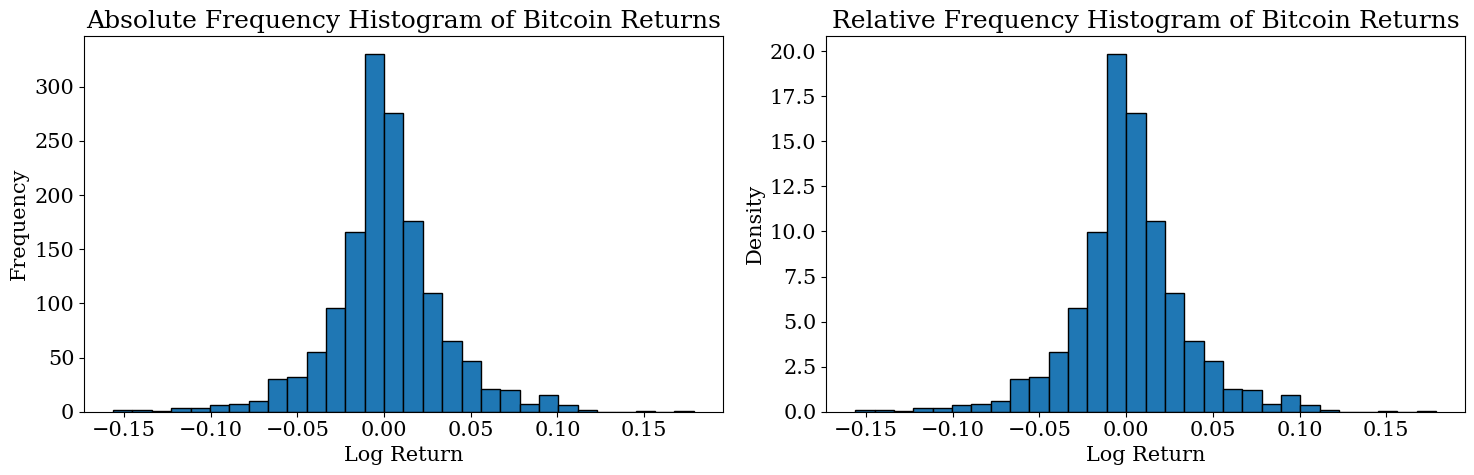

In [12]:
# Histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Log_Return'], bins=30, edgecolor='black')
plt.title('Absolute Frequency Histogram of Bitcoin Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Log_Return'], bins=30, edgecolor='black', density=True)
plt.title('Relative Frequency Histogram of Bitcoin Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [13]:
# Summary statistics
summary = df['Log_Return'].describe()
skewness = df['Log_Return'].skew()
kurtosis = (df['Log_Return'].kurt() + 3)
mode = df['Log_Return'].mode().iloc[0]

additional_stats = pd.DataFrame({'skewness': [skewness], 'kurtosis': [kurtosis], 'mode': [mode]})

additional_stats = additional_stats.applymap(lambda x: '{:.6f}'.format(x))

all_stats = pd.concat([summary, additional_stats.T], axis=0)
pd.set_option('display.float_format', '{:.4f}'.format)

In [14]:
all_stats

,0
count,1490.0000
mean,0.0015
std,0.0327
min,-0.1563
25%,-0.0134
50%,0.0001
75%,0.0169
max,0.1787
skewness,-0.004534
kurtosis,6.210246


In [15]:
# Jarque-Bera test
jb_stat, jb_pval = jarque_bera(df['Log_Return'])
print(f"Jarque-Bera Statistic: {jb_stat}, P-value: {jb_pval}")

Jarque-Bera Statistic: 633.9356977642958, P-value: 2.2009607091685898e-138


The histograms of Bitcoin returns, both in absolute and relative frequencies, exhibit a bell-shaped distribution centered around zero, which is characteristic of a normal distribution. However, upon closer inspection, there are some visible deviations from normality. The distribution appears to have slightly heavier tails than a standard normal distribution. This is further supported by the summary statistics. The skewness value of approximately -0.0045 is very close to zero, indicating that the distribution is nearly symmetric, with a slight skewness to the left. However, the kurtosis of 6.21 is significantly higher than the normal distribution's kurtosis of 3, which suggests that the Bitcoin returns have heavier tails and a higher peak, meaning extreme returns (both positive and negative) are more likely than in a normal distribution. Additionally, the Jarque-Bera test strongly rejects the null hypothesis of normality, given the extremely small p-value, basically equal to zero. This statistical evidence confirms that Bitcoin returns are not normally distributed, primarily due to excess kurtosis, with a higher likelihood of extreme movements than a normal distribution would predict.

### Task 3: Line Graph of Bitcoin Returns

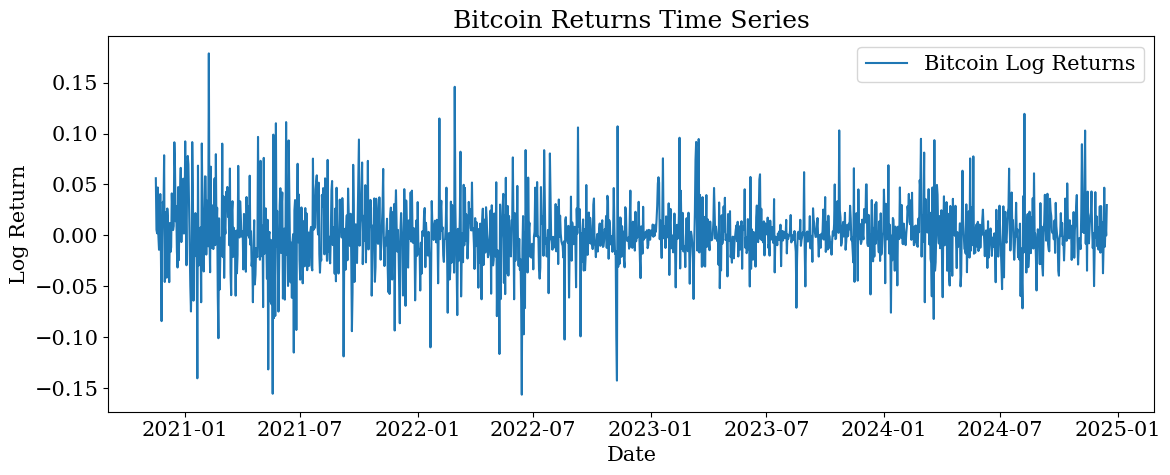

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df['Log_Return'], label='Bitcoin Log Returns')
plt.title('Bitcoin Returns Time Series')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()

The Bitcoin log returns time series fluctuates around zero from November 2020 to December 2024, with values ranging between -0.15 and 0.15. No clear trend is observed, indicating the absence of a systematic drift and a relatively stable variance. Overall, this seems to suggests that Bitcoin log returns time series is stationary.

### Task 4: SACF of Bitcoin Returns

In [17]:
returns = df["Log_Return"].values

In [18]:
returns_acf_pacf = SACF_SPACF(returns,lag_max=21)
returns_acf_pacf

,ACF,PACF,Q-stat,Q-stat Prob
Lag,,,,
1,-0.0321,-0.0321,1.5378,0.2150
2,0.0285,0.0275,2.7533,0.2524
3,0.0088,0.0106,2.8702,0.4121
4,0.0371,0.0370,4.9273,0.2948
5,0.0070,0.0088,5.0004,0.4158
6,0.0078,0.0062,5.0916,0.5321
7,-0.0073,-0.0080,5.1708,0.6391
8,-0.0451,-0.0478,8.2194,0.4123
9,0.0611,0.0584,13.8287,0.1286


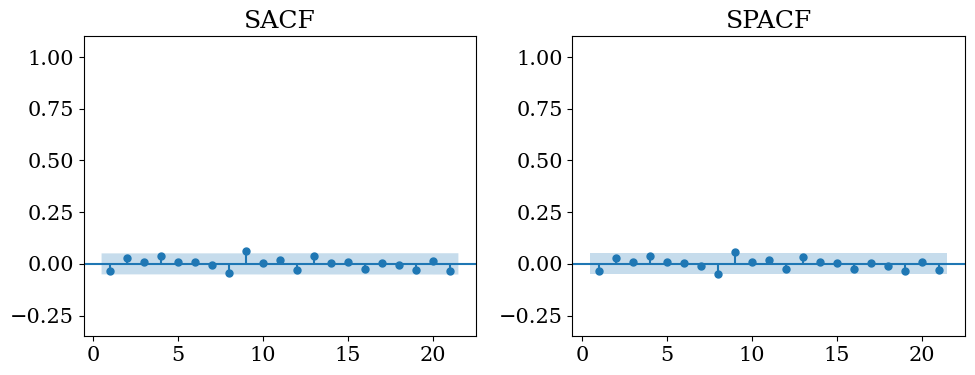

In [19]:
SACF_SPACF_plot(returns, lag_max=21, ylim=[-0.35,1.1])

The correlogram (SACF) of Bitcoin log returns over 21 lags shows that the sample autocorrelation values remain close to zero across all lags, with none appearing statistically significant as they fall within the confidence bands (with the only exception of lag 9 which is slightly above the upper bound of the confidence interval). This indicates a lack of serial correlation, namely that past returns do not provide predictive information for future returns. The pattern observed is consistent with a memory-less white noise process, which is characterized by zero autocorrelation at all lags after lag zero.

### Task 5: CER Model (Constant Only)

In [20]:
df_CER = df.copy()
X = np.ones((len(df_CER['Log_Return']), 1))
y = df_CER["Log_Return"]
CER_model = sm.OLS(y, X)
results_CER = CER_model.fit()
print(results_CER.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 19 Mar 2025   Prob (F-statistic):                nan
Time:                        20:41:22   Log-Likelihood:                 2984.1
No. Observations:                1490   AIC:                            -5966.
Df Residuals:                    1489   BIC:                            -5961.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.794      0.0

In [21]:
# To check that CER constant is sample mean of log returns

constant_CER = df_CER["Log_Return"].mean()
print(constant_CER)

0.0015182702285181004


The value of the constant derived from the CER model (0.0015) represents the average log return of Bitcoin over the selected period. Having a p-value equal to 0.073, the average log return of Bitcoin, despite being slightly positive, is not statistically different from zero at the 5% confidence level, further pointing towards the hyphothesis of the Bitcoin log returns time series being a white noise process.

### Task 6: AR/MA Model with Constant

In [22]:
# Test with White Noise process, namely ARIMA(0,0,0)

WN_model = sm.tsa.statespace.SARIMAX(
    returns,
    order=(0, 0, 0),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_WN = WN_model.fit()
print(results_WN.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00203D+00    |proj g|=  4.62882D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     16      1     0     0   2.225D-05  -2.002D+00
  F =  -2.0020261659626617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:                        SARIMA

 This problem is unconstrained.


In [23]:
# Test with ARMA model up to three terms

models = [
    (0, 0, 1),  # ARMA(0,1)
    (1, 0, 0),  # ARMA(1,0)
    (1, 0, 1),  # ARMA(1,1)
    (1, 0, 2),  # ARMA(1,2)
    (2, 0, 1),  # ARMA(2,1)
    (2, 0, 2),  # ARMA(2,2)
    (3, 0, 2),  # ARMA(3,2)
    (2, 0, 3),  # ARMA(2,3)
    (3, 0, 3)   # ARMA(3,3)
]

model_results = {}

for order in models:
    print(f"\nFitting ARMA{order} model...\n")
    model = sm.tsa.statespace.SARIMAX(
        returns,
        order=order,
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    results = model.fit()
    
    model_results[order] = {"AIC": results.aic, "BIC": results.bic}
    
    print(results.summary())


Fitting ARMA(0, 0, 1) model...

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00084D+00    |proj g|=  5.16364D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     23      1     0     0   5.705D-03  -2.001D+00
  F =  -2.0008437244265775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2981.257
Date:                Wed, 19 Mar 2025   AIC                          -5956.514
Time:                        20:41:22   BIC                          -5940.599
Sample:                     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     18      1     0     0   9.387D-03  -2.003D+00
  F =  -2.0025423657161547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2983.788
Date:                Wed, 19 Mar 2025   AIC                          -5961.576
Time:                        20:41:22   BIC                          -5945.659
Sample:                     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.00107D+00    |proj g|=  5.22586D-03

At iterate   10    f= -2.00108D+00    |proj g|=  4.40617D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   2.932D-04  -2.001D+00
  F =  -2.0010767699193850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(1, 0, 1)   Log Likelihood                2981.604
Date:                Wed, 19 Mar 2025   AIC                   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      6      1     0     0   4.617D-03  -2.000D+00
  F =  -1.9997762362346598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(1, 0, 2)   Log Likelihood                2979.667
Date:                Wed, 19 Mar 2025   AIC                          -5949.333
Time:                        20:41:23   BIC                          -5922.811
Sample:                     

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      7      1     0     0   5.514D-03  -2.001D+00
  F =  -2.0014161416913696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(2, 0, 1)   Log Likelihood                2982.110
Date:                Wed, 19 Mar 2025   AIC                          -5954.220
Time:                        20:41:23   BIC                          -5927.694
Sample:                     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.99863D+00    |proj g|=  7.97082D-02

At iterate   10    f= -1.99866D+00    |proj g|=  6.61497D-02

At iterate   15    f= -1.99866D+00    |proj g|=  1.19182D-02

At iterate   20    f= -1.99866D+00    |proj g|=  5.45008D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     42      1     0     0   1.955D-03  -1.999D+00
  F =  -1.9986650601776335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1490
Model:               SARIMAX(2, 0, 3)   Log Likelihood                2978.011
Date:                Wed, 19 Mar 2025   AIC                          -5942.022
Time:                        20:41:24   BIC                          -5904.895
Sample:                     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The analysis performed in Task 3, 4 and 5 seemed to indicate that the time series of Bitcoin log returns exhibited a behaviour similar to that of a white noise process. Indedd, the plot of the log returns over the selected time period showed that the observations fluctuated around zero, with a relatively stable variance, and the CER model confirmed this insight by proving that the average log return of Bitcoin over the period was not statistically different from zero. Furthermore, the correlogram of the log return time series showed no clear pattern, with all the lags being within the confidence band, therefore indicating lack of serial autocorrelation, another feature of the white noise process.

### Task 7: Residual Correlogram

In [24]:
residuals = results_WN.resid
residuals_acf_pacf = SACF_SPACF(residuals, lag_max=21)
residuals_acf_pacf

,ACF,PACF,Q-stat,Q-stat Prob
Lag,,,,
1,-0.0321,-0.0321,1.5371,0.2151
2,0.0285,0.0275,2.7524,0.2525
3,0.0089,0.0107,2.8705,0.4120
4,0.0371,0.0370,4.9269,0.2949
5,0.0070,0.0088,4.9997,0.4159
6,0.0078,0.0062,5.0908,0.5322
7,-0.0072,-0.0080,5.1692,0.6393
8,-0.0451,-0.0478,8.2201,0.4123
9,0.0610,0.0583,13.8136,0.1291


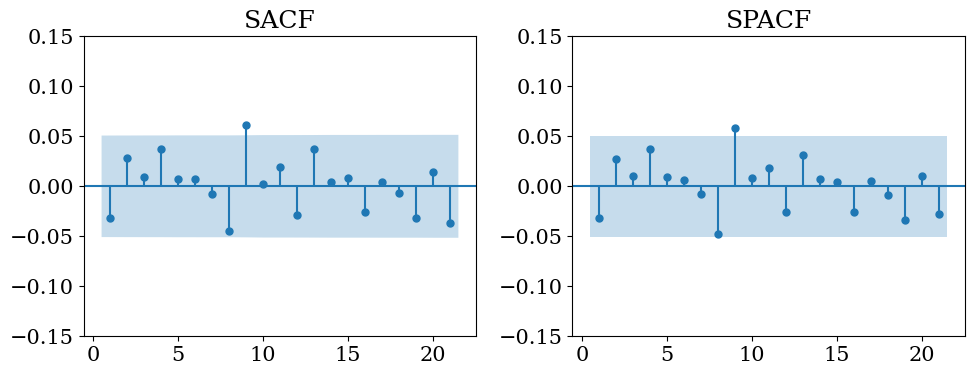

In [25]:
SACF_SPACF_plot(residuals, lag_max=21, ylim = [-0.15, 0.15])

The correlogram of the residuals shows that their series does not exhibit significant autocorrelation at any lag, with all the values (except for lag 9, which shows a minor spike, that could however be due to randomness) being within the confidence band. This suggests that the model was correctly specified, as the residuals show the lack of autocorrelation that is typical of a white noise, which is the process they should theoretically follow. This indicates that the model effectively captures the time series dynamics and that it does not leave behind any systematic patterns

### Task 8: Jarque-Bera Test on Residuals

In [26]:
# Jarque-Bera test on residuals
jb_stat, jb_pval = jarque_bera(residuals)
print(f"Jarque-Bera Statistic: {jb_stat}, P-value: {jb_pval}")

Jarque-Bera Statistic: 633.6644274655773, P-value: 2.5206809931407365e-138


The Jarque-Bera test on the residuals of the White noise model yields a statistic of 633.66 and an extremely low p-value (2.52e-138), rejecting the null hypothesis of normality at any conventional significance level (e.g., 0.05). The non-normality of residuals might undermine the validity of the results obtained in task 6, especially given that one of the key assumptions underlying MLE is that the residuals are white noise processes that follow a normal distribution. Indeed, while the residuals exhibit properties of a white noise process in terms of lack of autocorrelation, the significant deviation from normality suggests that MLE estimates may not be fully reliable. The violation of normality could lead to inefficiencies in parameter estimation and potentially incorrect inferences. Therefore, while the model captures the dynamics of Bitcoin log returns well in terms of autocorrelation, the non-normality of residuals suggests that alternative estimation methods or models, such as those accounting for heavy-tailed distributions (e.g., GARCH models), may be more appropriate.

### Task 9: Compare ICs (CER vs. AR Model)

In [27]:
model_results["CER"] = {"AIC": results_CER.aic, "BIC": results_CER.bic}
model_results["White noise"] = {"AIC": results_WN.aic, "BIC": results_WN.bic}

results_df = pd.DataFrame.from_dict(model_results, orient='index') # turn into a dictionary for better visualization

print("\nModel Comparison Table:")
print(results_df.sort_values(by="AIC"))  # Sorting by AIC for better comparison


Model Comparison Table:
                   AIC        BIC
CER         -5966.2432 -5960.9367
White noise -5962.0380 -5951.4263
(1, 0, 0)   -5961.5762 -5945.6587
(0, 0, 1)   -5956.5143 -5940.5987
(1, 0, 1)   -5955.2088 -5933.9880
(2, 0, 1)   -5954.2201 -5927.6942
(1, 0, 2)   -5949.3332 -5922.8106
(2, 0, 2)   -5947.3874 -5915.5603
(3, 0, 2)   -5945.6193 -5908.4877
(2, 0, 3)   -5942.0219 -5904.8950
(3, 0, 3)   -5939.5423 -5897.1116


The comparison of information criteria (AIC and BIC) among the estimated ARMA models suggests that the best-performing one is the simple CER model, with the White Noise ranking second both in terms of AIC and BIC. The CER model has the lowest AIC (-5966.24) and the lowest BIC (-5960.94), indicating that it provides a better fit to the data while also considering model complexity. Since lower values of AIC and BIC indicate a better trade-off between goodness-of-fit and parsimony, these results imply that the CER model captures important dynamics in the Bitcoin log returns that the other models fail to account for. The difference, especially with the White Noise, is relatively small but still suggests that assuming a constant expected return (CER) is preferable to modeling Bitcoin returns in more complex ways.